Copyright (c) 2022 Valentin Hartmann. All rights reserved.  
Released under Apache 2.0 license as described in the file LICENSE.

In [1]:
import math
import scipy.integrate as integrate
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import warnings

plt.rcParams.update({'font.size': 14,
                     'pdf.fonttype': 42}) # TrueType font as requested by PETS

# SVT

Our goal in this section is to demonstrate the advantage of using ODP analysis over standard DP analysis for releasing a sparse vector via SVT. We consider a 100-dimensional vector and want to release the indices and values of those entries whose absolute value lies above the threshold $T=500$. For more details see Sec. 4.1 of the paper.

We start by defining some constants.

In [2]:
Delta = 1
c = 20
eps_1_plus_eps_2 = 0.5
eps_3 = 0.5

For computing the optimal $\varepsilon_1,\varepsilon_2$ for a total budget of $\alpha = \varepsilon_1 + \varepsilon_2$ we solve the system of equations
$$
\begin{align}
\varepsilon_1+\varepsilon_2 &= \alpha\\
\frac{\varepsilon_1}{\varepsilon_2} &= \frac{1}{(2c)^{2/3}}.
\end{align}
$$
We get
$$
\begin{align}
\varepsilon_1 &= \frac{1}{1+\frac{1}{(2c)^{2/3}}} \frac{1}{(2c)^{2/3}} \alpha\\
\varepsilon_2 &= \alpha - \varepsilon_1.
\end{align}
$$

In [3]:
def split_budget_eps_1_2(budget, c):
    eps_1 = (1/(1+(1/math.pow(2*c, 2/3)))) * (1/math.pow(2*c,2/3)) * budget
    eps_2 = budget - eps_1
    return eps_1, eps_2

Setting $\alpha=0.5$ and $c=20$ yields:

In [4]:
eps_1, eps_2 = split_budget_eps_1_2(eps_1_plus_eps_2, c)
print(f'epsilon_1 = {eps_1}, epsilon_2 = {eps_2}')

epsilon_1 = 0.039382262580038824, epsilon_2 = 0.46061773741996115


We will compute an upper bound on the expected noise added with an ODP analysis using Chebyshev's inequality. For this we need to compute the expected number of released vector entries and the variance of this count. We first compute the probability $\mathbb{P}(\nu_i - \rho \geq T_i - q_i(\mathbf{x}))$ that a given entry is released.
We have $\rho \sim \text{Lap}(\Delta/\varepsilon_1)$ and $\nu_i \sim \text{Lap}(2c\Delta/\varepsilon_2)$. Since the distribution of $\rho$ is symmetric around 0, $\nu_i - \rho$ follows the same distribution as $\nu_i + \rho$. Letting $b_1 = \Delta/\varepsilon_1$ and $b_2 = 2c\Delta/\varepsilon_2$, we need to integrate over the convolution of the two Laplace distributions:
$$
\mathbb{P}(\nu_i - \rho \geq T_i - q_i(\mathbf{x})) = \int_{T_i - q_i(\mathbf{x})}^{\infty} \int_{-\infty}^{\infty} \frac{1}{2b_1} \exp\left(-\frac{|\rho|}{b_1}\right) \frac{1}{2b_2} \exp\left(-\frac{|\nu - \rho|}{b_2}\right) d\rho d\nu.
$$

We compute $b_1$ and $b_2$:

In [5]:
def compute_b_1(Delta, eps_1):
    return Delta / eps_1

In [6]:
def compute_b_2(c, Delta, eps_2):
    return 2*c*Delta / eps_2

In [7]:
b_1 = compute_b_1(Delta, eps_1)
b_2 = compute_b_2(c, Delta, eps_2)
print(f'b_1 = {b_1}, b_2 = {b_2}')

b_1 = 25.392141905702925, b_2 = 86.8399037867068


Now we can (numerically) compute the above integral. We consider $T_i=500$ and for the values of $q_i(\mathbf{x})$ only the cases 0 and 1000. Let
$$
p_0(1) = \mathbb{P}(\nu_i - \rho \geq 500),\quad p_0(0) = 1 - p_0(1)
$$
and
$$
p_{1000}(1) = \mathbb{P}(\nu_i - \rho \geq -500),\quad p_{1000}(0) = 1 - p_{1000}(1)
$$
be the four probabilities that we are interested in.
Due to the symmetry of the Laplace distribution we can further simplify $p_{1000}(1)$ as
$$
p_{1000}(1) = 1 - p_0(1).
$$

In [8]:
def integrand_single_all_args(b_1, b_2, rho, nu):
    fraction = 1 / (4*b_1*b_2)
    power = (-abs(rho)/b_1) - (abs(nu-rho)/b_2)
    return fraction * np.exp(power)

In [9]:
integrand_single = lambda rho, nu: integrand_single_all_args(b_1, b_2, rho, nu)

In [10]:
p_0_1, error_0_1 = integrate.nquad(integrand_single, [[-np.inf, np.inf], [500, np.inf]])
print(f'p_0(1) = {p_0_1}, error = {error_0_1}')

p_0(1) = 0.0017267930924315283, error = 1.484769393467497e-08


In [11]:
p_1000_1 = 1 - p_0_1

Let $n_0$, $n_{1000}$ be the number of small and the number of large queries, respectively, and assume w.l.o.g. the order $q_1(\mathbf{x})=,\dots,q_{n_0}(\mathbf{x})=0$, and $q_{n_0+1}(\mathbf{x})=\dots=q_{n_0+n_{1000}}(\mathbf{x}) = 0$. For $i=1,\dots,n_0$ let $X_i \sim \text{Ber}(p_0)$ be the Bernoulli random variable that is 1 if the corresponding noisy query with $q_i(\mathbf{x}) = 0$ exceeds the threshold, and likewise $X_i \sim \text{Ber}(p_{1000}),\ i=n_0,\dots,n_0+n_{1000},$ for the queries with $q_i(\mathbf{x}) = 1000$. We are interested in the expectation and the variance of the sum
$$
S = \sum_{k=1}^{n_0+n_{1000}} X_i.
$$
We can compute the expectation easily via its linearity from $p_0$ and $p_1$:
$$
\mathbb{E}(S) = n_0 p_0(1) + n_{1000} p_{1000}(1).
$$

In [12]:
def compute_expectation_S(n_0, n_1000, p_0_1, p_1000_1):
    return n_0*p_0_1 + n_1000*p_1000_1

The variance can be computed as
\begin{align*}
\text{Var}(S) &= \sum_i \sum_j \text{Cov}(X_i, X_j)\\
&= n_0 \text{Var}(X_1) + n_{1000} \text{Var}(X_{n_0+1}) + n_0(n_0-1)\text{Cov}(X_1,X_2) + n_{1000}(n_{1000}-1)\text{Cov}(X_{n_0+1},X_{n_0+2}) + n_0 n_{1000} \text{Cov}(X_1,X_{n_0+1})
\end{align*}
We have
$$
\text{Var}(X_1) = p_0(1) (1-p_0(1)),\quad \text{Var}(X_{n_0+1}) = p_{1000}(1) (1-p_{1000}(1)).
$$
For the mix terms we need to compute, for $(i=1,j=2),\ (i=n_0+1, j=n_0+2),\ (i=1, j=n_0+1)$,
\begin{align*}
\text{Cov}(X_i,X_j) &= \mathbb{E}(X_i X_j) - \mathbb{E}(X_i) \mathbb{E}(X_j)\\
&= \mathbb{P}(\nu_i - \rho \geq T_i - q_i(\mathbf{x}), \nu_j - \rho \geq T_j - q_j(\mathbf{x})) - \mathbb{E}(X_i) \mathbb{E}(X_j)\\
&= \int_{T_i - q_i(\mathbf{x})}^{\infty} \int_{T_j - q_j(\mathbf{x})}^{\infty} \int_{-\infty}^{\infty} \frac{1}{2b_1} \exp\left(-\frac{|\rho|}{b_1}\right) \frac{1}{2b_2} \exp\left(-\frac{|\nu_j - \rho|}{b_2}\right) \frac{1}{2b_2} \exp\left(-\frac{|\nu_i - \rho|}{b_2}\right) d\rho d\nu_j d\nu_i - \mathbb{E}(X_i) \mathbb{E}(X_j).
\end{align*}

Let
$$
g([a_1, a_2], [b_1, b_2]) = \int_{a_1}^{a_2} \int_{b_1}^{b_2} \int_{-\infty}^{\infty} \frac{1}{2b_1} \exp\left(-\frac{|\rho|}{b_1}\right) \frac{1}{2b_2} \exp\left(-\frac{|\nu_j - \rho|}{b_2}\right) \frac{1}{2b_2} \exp\left(-\frac{|\nu_i - \rho|}{b_2}\right) d\rho d\nu_j d\nu_i.
$$
Note that $g$ is invariant w.r.t. swapping $[a_1, a_2]$ and $[b_1, b_2]$.
We have to compute $\text{Cov}(X_1,X_2)$, $\text{Cov}(X_{n_0+1},X_{n_0+2})$ and $\text{Cov}(X_1,X_{n_0+1})$, and thus the values $g([500,\infty], [500, \infty])$, $g([-500,\infty], [-500, \infty])$ and $g([500,\infty], [-500, \infty])$. To save computation and avoid the numerical problems that scipy has with computing $g([-500,\infty], [-500, \infty])$ directly, we rewrite $g([500,\infty], [-500, \infty])$ as
$$
g([500,\infty], [-500, \infty]) = g([500,\infty], [500, \infty]) + g([500,\infty], [-500, 500])
$$
and $g([-500,\infty], [-500, \infty])$ as
\begin{align*}
g([-500,\infty], [-500, \infty]) &= 1 - (g([-\infty,-500], [-500, \infty]) + g([-500, \infty], [-\infty,-500]) + g([-\infty,-500], [-\infty,-500]))\\
&= 1 - (2g([-\infty,-500], [-500, \infty]) + g([-\infty,-500], [-\infty,-500]))\\
&= 1 - (2g([-\infty,-500], [-500, \infty]) + g([500,\infty], [500, \infty]))\\
&= 1 - (2g([500,\infty], [-500, \infty]) + g([500,\infty], [500, \infty]))\\
&= 1 - (2(g([500,\infty], [500, \infty]) + g([500,\infty], [-500, 500])) + g([500,\infty], [500, \infty]))\\
&= 1 - (3g([500,\infty], [500, \infty]) + 2g([500,\infty], [-500, 500])),
\end{align*}
where we exploit the symmetry of the joint distribution $(\nu_i-\rho, \nu_j-\rho)$.
We hence only have to compute the values $g([500,\infty], [500, \infty])$ and $g([500,\infty], [-500, 500])$.

In [13]:
def integrand_cov_i_j_all_args(b_1, b_2, rho, nu_j, nu_i):
    fraction = 1 / (8*b_1*b_2*b_2)
    power = (-abs(rho)/b_1) - (abs(nu_j-rho)/b_2) - (abs(nu_i-rho)/b_2)
    return fraction * np.exp(power)
                               
integrand_cov_i_j = lambda rho, nu_j, nu_i: integrand_cov_i_j_all_args(b_1, b_2, rho, nu_j, nu_i)

In [14]:
def compute_variance_X_i(p):
    return p*(1-p)

In [15]:
def compute_integrals_for_covariance():
    # The order of the limits is reversed as compared to how g is defined, because nquad takes the innermost limits first.
    # But it also does not really matter, since we can change the order of integration.
    integration_limits_list = [[[500, np.inf], [500, np.inf]], [[-500, 500], [500, np.inf]]]
    integrals = []
    errors = []
    for integration_limits in integration_limits_list:
        integration_limits.insert(0, [-np.inf, np.inf]) # integration limits for rho
        curr_integral, error = integrate.nquad(integrand_cov_i_j, integration_limits)
        integrals.append(curr_integral)
        errors.append(error)
    print('Integral errors:')
    print(f'Integral 1: {errors[0]}, Integral 2: {errors[1]}')
    return integrals

In [16]:
def compute_variance_S(n_0, n_1000, p_0_1, p_1000_1, integrals):
    variances = n_0*compute_variance_X_i(p_0_1) + n_1000*compute_variance_X_i(p_1000_1)
        
    covariances = 0
    covariances += n_0*(n_0-1) * (integrals[0] - p_0_1*p_0_1)
    covariances += n_1000*(n_1000-1) * ((1-(3*integrals[0] + 2*integrals[1])) - p_1000_1*p_1000_1)
    covariances += n_0*n_1000 * (integrals[0] + integrals[1] - p_0_1*p_1000_1)
    
    return variances + covariances

In [17]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="The maximum number of subdivisions")
    integrals_for_covariance = compute_integrals_for_covariance() # This may take a couple of minutes

Integral errors:
Integral 1: 1.4892516520505813e-08, Integral 2: 7.326226175516681e-07


We want to find an upper bound for the expected variance of the noise that needs to be added to the released vector entries according to the ODP analysis. This variance depends on the value of $S$ and it is a monotonically increasing function in $S$. Call this function $f$. We hence want to find an upper bound on
$$
\mathbb{E}(f(S)) = \sum_{i=0}^{c-1} f(i) \mathbb{P}(S=i) + f(c) \mathbb{P}(S\geq c).
$$

Let $\mu$ be the expectation and $\sigma^2$ the variance of $S$. Chebyshev's inequality states that, for any $r>0$,
$$
\mathbb{P}(\lvert S-\mu\rvert\geq r)\leq \frac{\sigma^2}{r^2}.
$$
Note that we can exchange the larger or equal inside the probability by a strictly smaller for all practical purposes, which we will use below.

Let $t = \lceil\mu\rceil-\mu$. Then the inequality implies, for $k=0,1,\dots$,
$$
\mathbb{P}(S\geq \lceil\mu\rceil + k)\leq \frac{\sigma^2}{(t+k)^2}
$$
and
$$
\mathbb{P}(S< \lceil\mu\rceil + k)\geq 1 - \frac{\sigma^2}{(t+k)^2}.
$$
Further,
\begin{equation}
f(\lceil\mu\rceil + k) \mathbb{P}(S\geq\lceil\mu\rceil + k) + f(\lceil\mu\rceil + k+1) \mathbb{P}(S\geq\lceil\mu\rceil + k+1) \leq f(\lceil\mu\rceil + k) \left(\frac{\sigma^2}{(t+k)^2} - \frac{\sigma^2}{(t+k+1)^2}\right) + f(\lceil\mu\rceil + k+1) \frac{\sigma^2}{(t+k+1)^2},\label{eq:estimate_sum_of_two}\tag{1}
\end{equation}
since due to the monotonicity of $f$ the value of the sum is maximized if we shift the maximal amount of probability mass to $\lceil\mu\rceil + k + 1$. The same bound holds when replacing $\mathbb{P}(S\geq\lceil\mu\rceil + k)$ by $\mathbb{P}(S=\lceil\mu\rceil + k)$, and when replacing both $\mathbb{P}(S\geq\lceil\mu\rceil + k)$ by $\mathbb{P}(S=\lceil\mu\rceil + k)$ and $\mathbb{P}(S\geq\lceil\mu\rceil + k+1)$ by $\mathbb{P}(S=\lceil\mu\rceil + k+1)$.

Let $K=c-\lceil\mu\rceil$. The repeated application of $\eqref{eq:estimate_sum_of_two}$ yields
\begin{align*}
\mathbb{E}(f(S)) &= \sum_{i=0}^{c-1} f(i) \mathbb{P}(S=i) + f(c) \mathbb{P}(S\geq c)\\
&\leq f(\lceil\mu\rceil - 1) \left(1 - \frac{\sigma^2}{t^2}\right) + \sum_{k=0}^{K-1} f(\lceil\mu\rceil + k) \left(\frac{\sigma^2}{(t+k)^2} - \frac{\sigma^2}{(t+k+1)^2}\right) + f(c) \frac{\sigma^2}{(t+K)^2}.\label{eq:final_E_S_bound}\tag{2}
\end{align*}
Note the different summation limits in the two lines. We bound all summands with $i\geq\lceil\mu\rceil$ in the first sum using the upper bound $\eqref{eq:estimate_sum_of_two}$ $K$ times. We put the remaining probability mass
$$
1 - \frac{\sigma^2}{t^2} = 1 - \left(\sum_{k=0}^{K-1} \left(\frac{\sigma^2}{(t+k)^2} - \frac{\sigma^2}{(t+k+1)^2}\right) + \frac{\sigma^2}{(t+K)^2}\right)
$$
towards the summands with $i<\lceil\mu\rceil$, and use the fact that $f(i)\leq f(\lceil\mu\rceil - 1)$ for $i=0,\dots,\lceil\mu\rceil - 1$.
We assume that $\mu$ is not an integer, so that $t\neq 0$ and we do not divide by 0. Otherwise we need to start the summation at $k=1$ instead of $k=0$ and have $f(\mu) \left(1 - \frac{\sigma^2}{(0+1)^2}\right)$ as the first summand in Eq. $\eqref{eq:final_E_S_bound}$ instead of $f(\lceil\mu\rceil - 1) \left(1 - \frac{\sigma^2}{t^2}\right)$.

If $\frac{\sigma^2}{t^2}>1$, we get an even better bound, since we only need to sum up probability bounds until we have reached a probability of 1. Let $k^*$ be the smallest non-negative integer such that $\frac{\sigma^2}{(t+k)^2}<1$. Then
$$
\mathbb{E}(f(S)) \leq f(\lceil\mu\rceil + k^* - 1) \left(1 - \frac{\sigma^2}{(t+k^*)^2}\right) + \sum_{k=k^*}^{K-1} f(\lceil\mu\rceil + k) \left(\frac{\sigma^2}{(t+k)^2} - \frac{\sigma^2}{(t+k+1)^2}\right) + f(c) \frac{\sigma^2}{(t+K)^2}.
$$

We already have functions that compute the expectation and variance of $S$. What remains is a function for computing $f$.
For a given per-entry budget $\varepsilon$, the standard deviation of the added Laplace noise is
$$
\sqrt{2}\frac{\Delta}{\varepsilon}.
$$
In the non-ODP case we have a budget of
$$
\varepsilon = \frac{\varepsilon_3}{c}
$$ per entry.

Let $c'$ be the number of released entries. Then in the ODP case we have a budget of
$$
\varepsilon = \frac{1}{c'}\left(\varepsilon_3 + \frac{c-c'}{c}\varepsilon_2\right)
$$
per entry (see paper).

In [18]:
def std_dev_laplace(Delta, eps):
    return math.sqrt(2) * Delta / eps

In [19]:
def non_odp_eps_per_entry(eps_3, c):
    return eps_3 / c

In [20]:
def odp_eps_per_entry(eps_2, eps_3, c, c_prime):
    eps_per_entry = eps_3 + ((c-c_prime)/c)*eps_2
    eps_per_entry /= c_prime
    return eps_per_entry

Now the function $f$:

In [21]:
def compute_variance_laplace_odp(Delta, eps_2, eps_3, c, c_prime):
    if c_prime == 0:
        return 0
    return std_dev_laplace(Delta, odp_eps_per_entry(eps_2, eps_3, c, c_prime))

And the upper bound for $\mathbb{E}(f(S))$:

In [22]:
def compute_upper_bound_expected_variance_laplace(Delta, eps_2, eps_3, c, n_0, n_1000, p_0_1, p_1000_1, integrals):
    mu = compute_expectation_S(n_0, n_1000, p_0_1, p_1000_1)
    mu_int = math.ceil(mu)
    t = mu_int - mu
    sigma_2 = compute_variance_S(n_0, n_1000, p_0_1, p_1000_1, integrals)
    f = lambda c_prime: compute_variance_laplace_odp(Delta, eps_2, eps_3, c, c_prime)
    
    bound = 0
    K = c - mu_int
    k = 0
    for k in reversed(range(K)):
        if sigma_2/math.pow(t, 2) >= 1:
            k += 1 # set k = k^*
            break
        fraction_1 = sigma_2 / math.pow(t+k, 2)
        fraction_2 = sigma_2 / math.pow(t+k+1, 2)
        bound += f(mu_int + k) * (fraction_1 - fraction_2)
    bound += f(mu_int+k-1) * (1 - (sigma_2/math.pow(t, 2) + k))
    bound += f(c) * (sigma_2 / math.pow(t+K, 2))
    
    worst_case_bound = compute_variance_laplace_odp(Delta, eps_2, eps_3, c, c) # We never release more than c entries
    return min(bound, worst_case_bound)

In [23]:
non_odp_std_dev = std_dev_laplace(Delta, non_odp_eps_per_entry(eps_3, c))
odp_std_dev_list = [compute_upper_bound_expected_variance_laplace(Delta, eps_2, eps_3, c, 100-num_large_entries, num_large_entries, p_0_1, p_1000_1, integrals_for_covariance) for num_large_entries in range(21)]

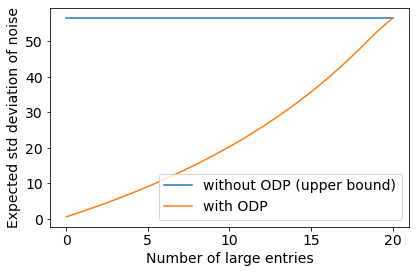

In [24]:
plt.plot(range(0,21), np.ones(21)*non_odp_std_dev, label='without ODP (upper bound)')
plt.plot(range(0,21), odp_std_dev_list, label='with ODP')
plt.xlabel('Number of large entries')
plt.ylabel('Expected std deviation of noise')
plt.legend()
plt.tight_layout()
plt.savefig('svt.pdf')

# ERM

In this section we investigate the ODP variant of output perturbation for releasing a noisy logistic regression model, but only its error lies below a given threshold. We compute the amount of noise that needs to be added to the error before the comparison with the threshold. For more details see Sec. 6.1 of the paper.

We start by computing $a$ from line 2 of Alg. 5.

In [25]:
def compute_a(n_train, n_test, Lambda):
    return max(2/n_test, 2*(np.exp(2/(n_train*Lambda)) - 1))

We want to plot the 95th percentile of the noise added to the model error.

In [26]:
def score_noise_quantile(a, epsilon_2, F):
    '''
    Computes the F-quantile of the noise added to the model error.
    F must be >= 1/2.
    '''
    
    laplace_param = a/epsilon_2
    return -laplace_param * np.log(2-2*F)

We define the different settings that we consider. In all settings 70% of the data is used for training and 30% is used for testing.

In [27]:
epsilons_2_s = [0.1, 0.2, 0.5]
dataset_sizes = range(1000, 5000)
fraction_test = 0.3 # fraction of test records
Lambda = 1
quantile = 0.95

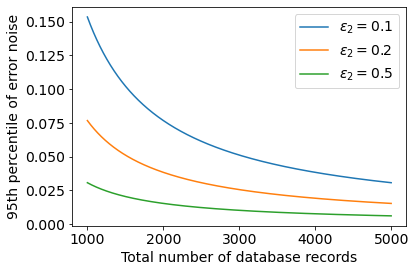

In [28]:
for epsilon_2 in epsilons_2_s:
    percentiles = [score_noise_quantile(compute_a((1-fraction_test)*size, fraction_test*size, Lambda), epsilon_2, quantile)
                   for size in dataset_sizes]
    plt.plot(dataset_sizes, percentiles, label=f'$\\varepsilon_2={epsilon_2}$')

plt.ylabel('95th percentile of error noise')
plt.xlabel('Total number of database records')
plt.legend()
plt.tight_layout()
plt.savefig('erm.pdf')